# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 8</span>


In this exercise sheet, we consider a particle in one dimension - described by the coordinate $x$ - subject to the following potential:

$$ V(x) = x^4 - \frac{5}{2}x^2. $$

Throughout this notebook we use dimensionless paremeters such that $\hbar = 1$, $k_B=1$ and $m = 1$.

Our main objective is to find the square of the ground state wave function $|\Psi_0(x)|^2$ and the ground state energy $E_0$ of this system at zero temperature. To do so, we apply a Variational Monte Carlo (VMC) simulation (exercise 08.1 and 08.2) as well as the Path Integral Ground State (PIGS) method (exercise 08.3). Then, we use the Path Integral Monte Carlo (PIMC) method to analyze the behaviour of the wavefunction for non-zero temperature (exercise 08.3).

The time-indepedent Schrödinger equation of the particle can also be solved numerically by computing the eigenvalues and the eigenvectors of a matrix equation (for more details on this approach see exercise description). In the figure below, we show the resulting sqaured wavefunctions of the ground state $|\Psi_0(x)|^2$, of the excited states $|\Psi_1(x)|^2$ and $|\Psi_2(x)|^2$, as well as the potential $V$ as a function of the position $x$. We also print the corresponding eigenenergies. This gives us an idea of the solution to the problem to which we can compare the results that we obtain using VMC and PIMC.

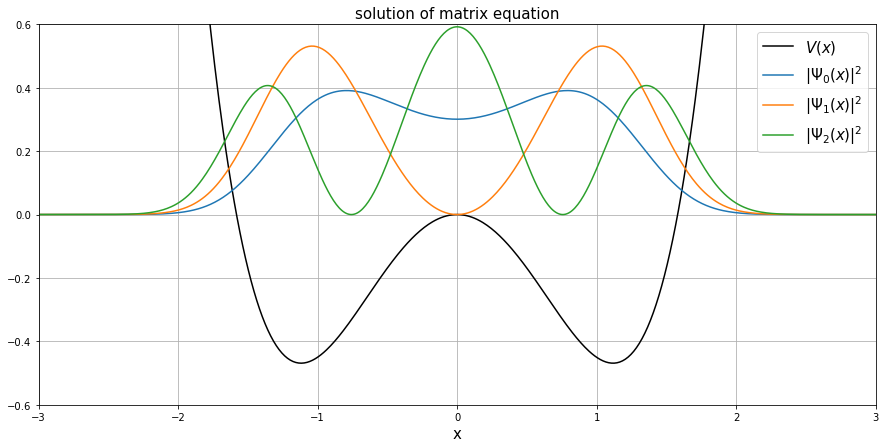

Ground state energy:  -0.46046587969271535
1st excited state energy:  0.0974247133176099
2nd excited state energy:  1.9717331343930198


In [65]:
import numpy as np
import matplotlib.pyplot as plt

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

E_0 = E[0] # ground state energy

# Plot a few things
plt.figure(figsize=(15,7))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="$V(x)$") # plot the potential
plt.plot(x,(psi[0])**2, label=r"$|\Psi_0(x)|^2$")
plt.plot(x,(psi[1])**2, label=r"$|\Psi_1(x)|^2$")
plt.plot(x,(psi[2])**2, label=r"$|\Psi_2(x)|^2$")
plt.title("solution of matrix equation", size=15)
plt.xlabel("x", size=15)
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))

plt.legend(fontsize=15)
plt.show()

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

### Exercise 08.1 & 08.2

For the application of a variational computation, we need a guess for the ground state wavefunction $\Psi_0$. We use:

$$ \Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}},$$
                               
motivated by the symmetry of the potential $V$ with two valleys whose position on the $x$-axis is modelled by $\mu$. The parameter $\sigma$ takes the width of the valley into account. 

To determine the best values of $\mu$ and $\sigma$, we apply the **variational principle**. It states that the expectation value of the Hamiltonian operator $\langle {\hat H} \rangle_T$ with respect to the trial wavefunction $\Psi_T^{\sigma,\mu}$ cannot be smaller than the actual ground state energy $E_0$:

$$ \langle {\hat H} \rangle_T = \frac{\langle \Psi_T^{\sigma,\mu}| {\hat H} | \Psi_T^{\sigma,\mu} \rangle}
{\langle \Psi_T^{\sigma,\mu} | \Psi_T^{\sigma,\mu} \rangle} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle} .$$

In other words, if we minimize $\langle {\hat H} \rangle_T$ as a function of $\mu$ and $\sigma$, we obtain the the wave function $\Psi_T^{\sigma,\mu}$ that describes the system most accurately. However, the result is not necessarily a good approximation of the actual ground state wavefunction $\Psi_0$ as we do not consider *all* wavefunctions but just a subset. 

Note, that we can write:

$$\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} = 
\int dx p(x) g(x),$$

with:

$$p(x) = \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \quad g(x) = \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}.$$

We can interpret $p$ as a probability density function. Then, we can compute the integral (for a given $\mu$ and $\sigma$) using the Metropolis algorithm with a uniform trial transition probability of step length $\delta$. The application of the Metropolis alogrithm is necessary because the integral $\langle {\hat H} \rangle_T$ cannot be solved analytically, whereas for the evaluation of $g$ we simply have to calculate the second derivative of $\Psi_T^{\sigma,\mu}$.

To find the minimum of $\langle {\hat H} \rangle_T$, we conduct a grid search over the parameters $\mu$ and $\sigma$. The range of the grid is $\mu \in [0.6, 1.0)$ and $\sigma \in [0.4, 0.8)$ with a resolution of $\Delta = 0.002$ for both parameters. Thus, we have to compute the value of $\langle {\hat H} \rangle_T$ for $200 \times 200 = 40000$ different parameter combinations. 

We dispay the result in the figure below as a heatmap. The value of $\langle {\hat H} \rangle_T$ for every parameter combination is the average of $M_{max}=250000$ Metropolis steps. One Metropolis step consists in the proposal of the movement of the particle. Here, we used $\delta = 2.5$ for all parameter combinations (below, we explain this choice more precisely). The minimum energy of $\langle {\hat H} \rangle_T = -0.447749$ is found for $\mu = 0.786$ and $\sigma = 0.622$. Since the minimum energy does not differ strongly from the numerical computation of the ground state energy of $E_0 = -0.46046587969271535$, we are confident that our trial wave function is somewhat close to the real solution.

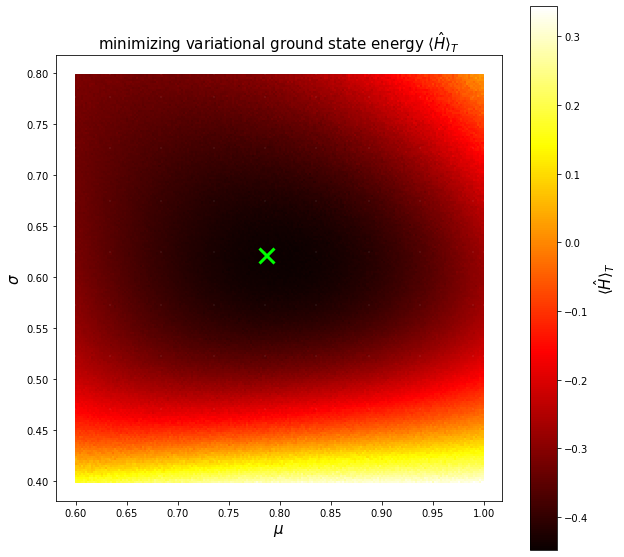

Minimum values are:
	E_min = -0.447749
	mu = 0.786
	sigma = 0.622


In [66]:
mu, sigma , E = np.loadtxt("data/VMC/opt_params.txt", delimiter=",", skiprows=1, unpack=True)

# find minimum energy
E_min = np.min(E)
min_index = np.argmin(E)
mu_min = mu[min_index]
sigma_min = sigma[min_index]

# plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
pc = ax.scatter(mu, sigma, c=E, marker="s", s=4, cmap="hot")
ax.plot(mu_min, sigma_min, marker="x", color="lime", markersize=15, markeredgewidth=3)
cb = fig.colorbar(pc)
cb.set_label(label=r"$\langle {\hat H} \rangle_T$", size=15)

ax.set_title(r"minimizing variational ground state energy $\langle {\hat H} \rangle_T$", size=15)
ax.set_xlabel(r"$\mu$", size=15)
ax.set_ylabel(r"$\sigma$", size=15)
ax.set_aspect("equal")

plt.show()

# print minimum values
print("Minimum values are:\n\t" + "E_min = " + str(E_min) + "\n\tmu = " + str(mu_min) + "\n\tsigma = " + str(sigma_min))

Now that we know which values of $\mu$ and $\sigma$ we should use, we anaylze in more detail the resulting energy $\langle {\hat H} \rangle_T$. The next figure shows the progressive mean of the computed energy $\langle {\hat H} \rangle_T$ from the Variational Monte Carlo computation using the Metropolis algorithm as a function of the number of steps $M$. In total, we again use $M_{max}=250000$ steps. We divide these steps into $N_{max} = 100$ blocks to compute the uncertainties using the blocking method. For the VMC simulation, we used $\delta = 2.5$ leading to an acceptance rate of $52.54 \%$. As already mentioned above, we also used this choice of $\delta$ for the energy computation for all parameter combinations of our grid search. Technically, we should have adjusted the value of $\delta$ for each combination to satisfy the $50 \%$ empirical rule. However, the fixed choice of $\delta$ still allows us to determine the minimum energy with high precision. 

In the figure, we also plot the numerical result from the matrix equation. As we can, both values are close but the VMC computation does not conerge exactly to the energy predicted by the matrix equation. This is not surprising as our guess $\Psi_T^{\sigma,\mu}$ for the ground state wavefunction - even for the best parameter choice - is not necessary the exact ground state function. In other words, using variational computation methods we in general expect a deviation from the exact result. However, since in this case the deviation is small, we conclude that our guess for the ground state wavefunction for the concrete choice of parameters is a good approximation to the real ground state wavefunction.

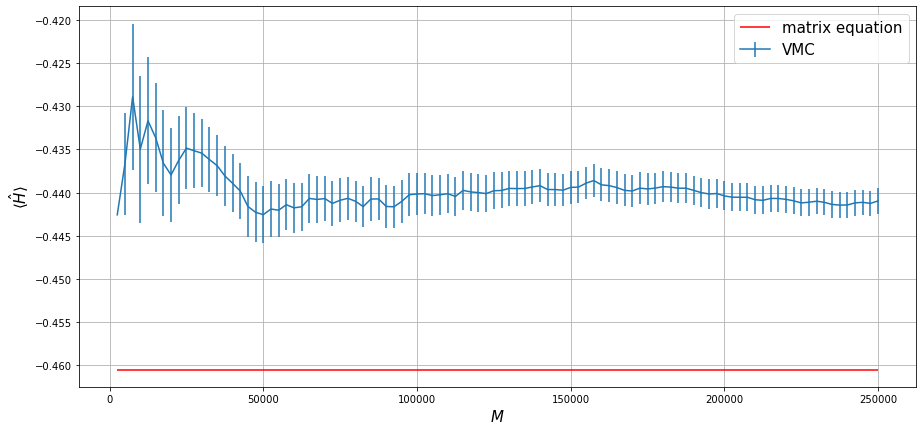

In [91]:
# variational results
M, E, E_err = np.loadtxt("data/VMC/E_vs_M.txt", skiprows=1, unpack=True, delimiter=",")

plt.figure(figsize=(15, 7))
plt.errorbar(M, E, E_err, label="VMC")
plt.hlines(E_matrix, min(M), max(M), color='r', label="matrix equation")

plt.xlabel(r"$M$", size=15)
plt.ylabel(r"$\langle {\hat H} \rangle$", size=15)
plt.grid()
plt.legend(fontsize=15)

plt.show()

To further check this impression, we can plot the probability density function $|\Psi_T^{\sigma,\mu}|^2$ that follows from our variational computation of the ground state wave function against the position $x$, as shown in the figure below. Additionally, we plot the probability density function resulting from the solution of the matrix equation as well as a histogram of the $M_{max}=250000$ steps of the Metropolis algorithm that we used for the VMC computation. For the histogram, we used $400$ bins in a range from $x=-5$ to $x=5$.

The histogram of the Metropolis steps is in agreement with the VMC result obtained by minimizing the ground state energy w.r.t. $\mu$ and $\sigma$. This is not surprising as the variational guess for the ground state wavefunction is the input of the Metropolis simulation (used for the computation of the ground state energy).

The probability density function from the solution of the matrix equation has a similar shape, though we observe slight deviations from our variational guess. Again, this is due to the fact that our variational approach systematically does not need to include the exact ground state wavefunction.

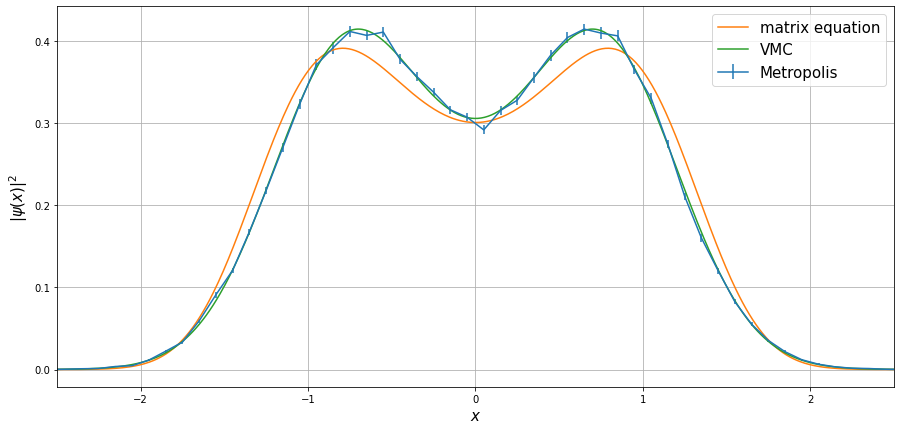

In [98]:
def psi2_analytic(x, mu, sigma):
    norm2 = 2 * np.sqrt(np.pi) * sigma * (1 + np.exp(-mu**2 / sigma**2))
    psi = np.exp(-(x - mu)**2 / (2 * sigma**2)) + np.exp(-(x + mu)**2 / (2 * sigma**2))
    return psi**2 / norm2
    
x_VMC, pdf, pdf_err = np.loadtxt("data/VMC/hist.txt", unpack=True, skiprows=1, delimiter = ",")

plt.figure(figsize=(15, 7))
plt.errorbar(x_VMC, pdf, pdf_err, label="Metropolis")
plt.plot(x, (psi[0])**2, label="matrix equation")
plt.plot(x, psi2_analytic(x, mu_min, sigma_min), label="VMC")

plt.xlabel("$x$", size=15)
plt.ylabel(r"$|\psi(x)|^2$", size=15)
plt.xlim(-2.5, 2.5)

plt.grid()
plt.legend(fontsize=15)
plt.show()

### Exercise 08.3

A more sophisticated way to compute the ground state wavefunction and the ground state energy of the given system is the PIGS method. Its basis is the isomporphism between a quantum particle and an *open* classical polymer. One parameter of the PIGS method is the number of "atoms" in the polymer, called timeslices. Another parameter is the imaginary time $\tau$. The larger we chose $\tau$, the more accurately approximates the result of the PIGS method the actual ground state of the system. Here, we use $300$ timeslices and start with an imaginary time of $\tau = 8$. 

Since the PIGS method uses the Metropolis algorithm, we can also specify a trial transition probability. We start with a uniform trial transition probability $\Psi_T(x)=1$. We display the results in the figure below. The top panels illustrate the total and potential energy as a function of the timeslice. Observe how the potential energy at both ends of the open polymer increases significantly. The total energy oscillates around $E_tot \approx -0.4$, which is roughly the ground state energy that we obtained from the matrix method and from the VMC computation. The bottom panel shows the histogram of the probability density function $|\Psi(x)|^2$ from the PIGS simulation. It is computed from the timeslices $120$ to $180$ (where the potential energy is stable). We use $400$ bins in a range from $x=-5$ to $x=5$. All of the computations here and in the following part of this exercise sheet are done using $N=20$ blocks with $L=4000$ Monte Carlo steps in each block. For the equilibration, $M=2000$ Monte Carlo steps are conducted.

The probability denstiy function of the PIGS method is in excellent agreement with the solution of the matrix equation, see figure. For comparison, we also plot the probability density function from the VMC computation.

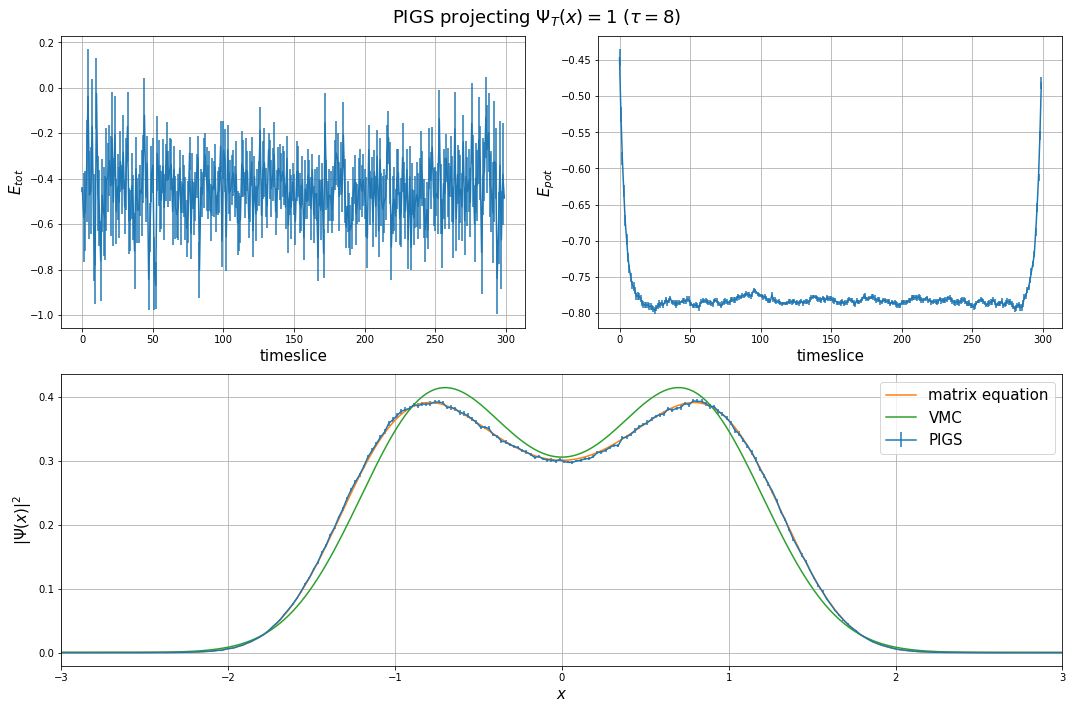

In [140]:
def plot_PIMC(directory, title, label, mu_min, sigma_min, x_matrix, psi0_matrix):
    """
    Plot Etot, Epot and pdf from PIMC computation.
    pdf is compared with result from matrix equation and from VMC.
    """
    
    timeslices, Ekin, Ekin_err = np.loadtxt(directory + "kinetic.dat", unpack=True)
    timeslices, Epot, Epot_err = np.loadtxt(directory + "potential.dat", unpack=True)
    x, pdf, pdf_err = np.loadtxt(directory + "probability.dat", unpack=True)
    
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(title, size=18)
    
    # kinetic energy
    ax1 = plt.subplot(221)
    ax1.errorbar(timeslices, Ekin + Epot, np.sqrt(Ekin_err**2 + Epot_err**2))
    ax1.set_xlabel("timeslice", size=15)
    ax1.set_ylabel(r"$E_{tot}$", size=15)
    ax1.grid()
    
    # potential energy
    ax2 = plt.subplot(222)
    ax2.errorbar(timeslices, Epot, Epot_err)
    ax2.set_xlabel("timeslice", size=15)
    ax2.set_ylabel(r"$E_{pot}$", size=15)
    ax2.grid()
    
    # pdf
    ax3 = plt.subplot(212)
    ax3.errorbar(x, pdf, pdf_err, label=label)
    ax3.plot(x_matrix, (psi0_matrix)**2, label="matrix equation")
    ax3.plot(x, psi2_analytic(x, mu_min, sigma_min), label="VMC")
    ax3.set_xlabel("$x$", size=15)
    ax3.set_ylabel(r"$|\Psi(x)|^2$", size=15)
    ax3.set_xlim((-3, 3))
    ax3.legend(fontsize=15)
    ax3.grid()
    
    plt.tight_layout()
    plt.show()
    
plot_PIMC("data/PIGS/tau8_uni/", r"PIGS projecting $\Psi_T(x)=1$ ($\tau = 8$)", "PIGS", mu_min, sigma_min, x, psi[0])

To improve the results, we apply the PIGS method with another trial transition probability. This time we use our guess for the ground state wavefunction from our VMC computation $\Psi_T(x) = \Psi_T^{\sigma,\mu}(x)$. The figure below shows the obtained results. Now, the potential energy does not increase a lot at the ends of the open polymer as we might expect (as we are now conducting a type of importance sampling). The plot of the probability density function does not immediately reveal an advantage over the uniform trial transition probability.

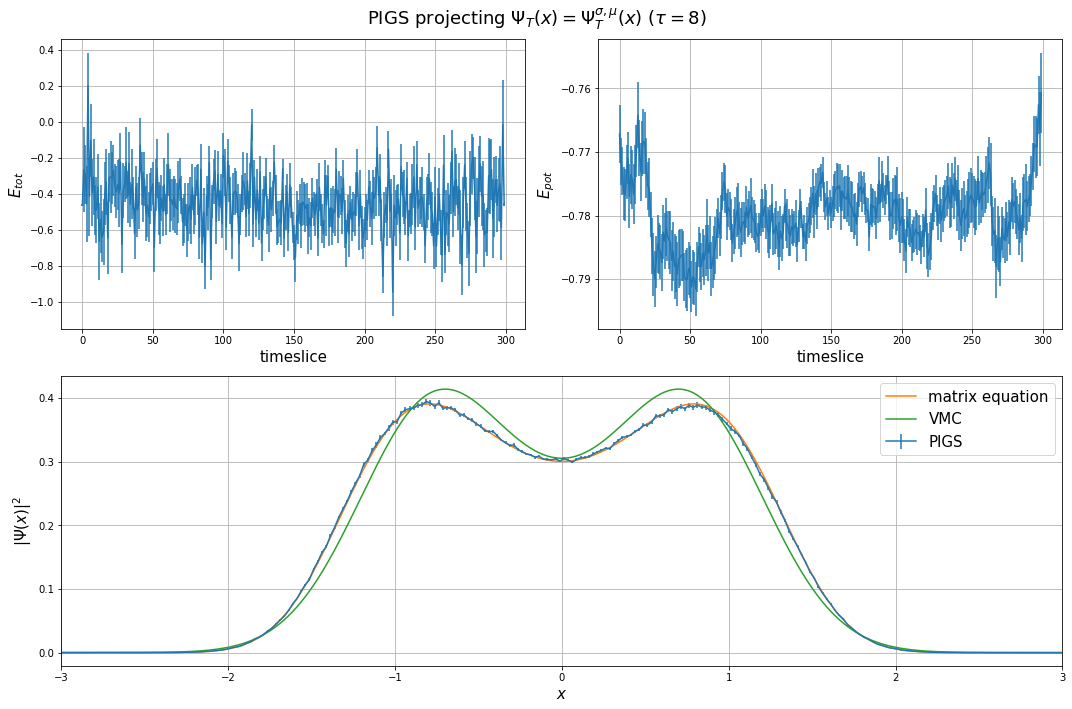

In [142]:
plot_PIMC("data/PIGS/tau8_var/", r"PIGS projecting $\Psi_T(x) = \Psi_T^{\sigma,\mu}(x)$ ($\tau = 8$)", "PIGS", mu_min, sigma_min, x, psi[0])

If we plot the probability denstiy function against the position $x$ for decreasing immaginary times (as in the figure below), we observe that the functional form begins to differ from the actual ground state. Here, we especially notice a difference between the two trial transition probabilities. In general, this difference appears to be larger when we use the uniform trial transition probability. If we use $\Psi_T(x)=\Psi_T^{\sigma,\mu}(x)$, we already use our knowledge about the ground state wavefunction for the Metropolis sampling. This kind of importance sampling increases the speed of convergence, such that a smaller value of $\tau$ already leads to a good approximation of the ground state wavefunction.

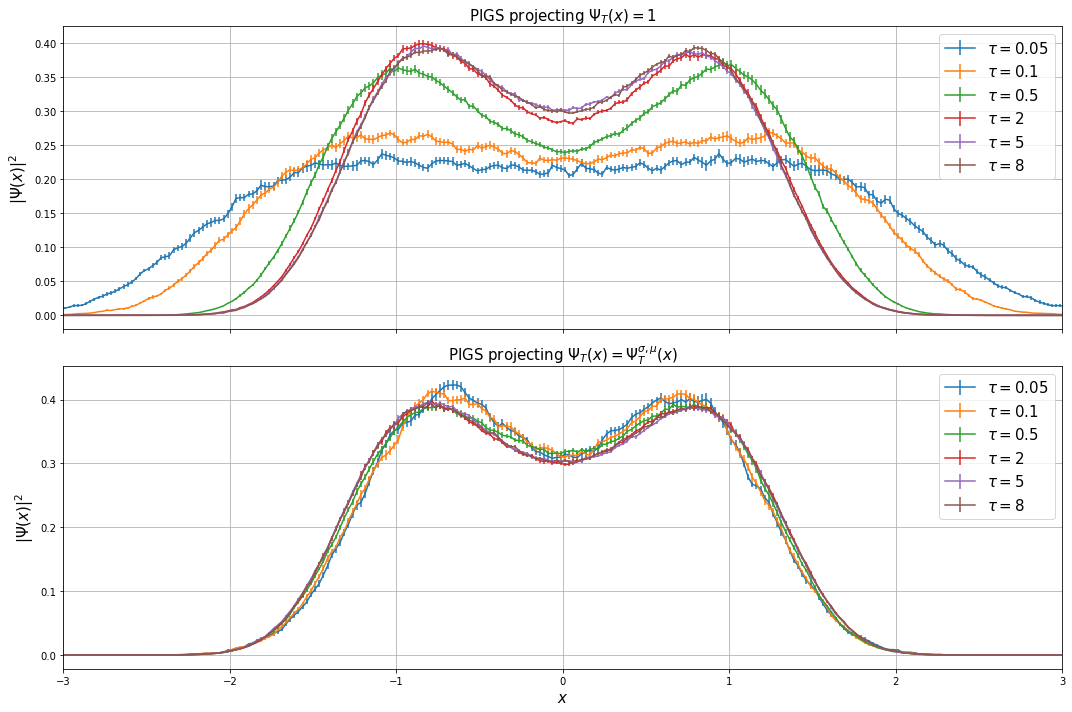

In [174]:
def plot_densities_PIGS(directory):
    """
    Plot pdfs for PIGS method for different immaginary times.
    Comparison of different trial wave functions.
    """
    
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    type_list = ["_uni", "_var"]
    file_list = ["tau0.05", "tau0.1", "tau0.5", "tau2", "tau5", "tau8"]
    tau = [0.05, 0.1, 0.5, 2, 5, 8]
    
    for i, typ in enumerate(type_list):
        for j, file in enumerate(file_list):
            x, pdf, pdf_err = np.loadtxt(directory + file + typ + "/probability.dat", unpack=True)
            ax[i].errorbar(x, pdf, pdf_err, label=r"$\tau=$"+str(tau[j]))
        ax[i].set_ylabel(r"$|\Psi(x)|^2$", size=15)
        ax[i].legend(fontsize=15)
        ax[i].grid()
        ax[i].set_xlim((-3, 3))
    ax[0].set_title(r"PIGS projecting $\Psi_T(x)=1$", fontsize=15)
    ax[1].set_title(r"PIGS projecting $\Psi_T(x)=\Psi_T^{\sigma,\mu}(x)$", fontsize=15)
    ax[1].set_xlabel(r"$x$", size=15)
    
    plt.tight_layout()
    plt.show()

        
plot_densities_PIGS("data/PIGS/")

Finally, we analyze the probability density function of the particle in our 1D potential as we increase the temperature. For this purpose, we use the PIMC method. It basically works the same as PIGS with the difference that at non-zero temperatures the polymer is *closed* and there is no immaginary time. Here, we only use $30$ timeslices. For the histograms of the probability density functions, we use $400$ bins from $x=-10$ to $x=10$ from all timeslices.

In the figure below, the resulting probability density functions for a variety of temperatures $T$ are plotted against the position $x$. As we can clearly see, the probability density function becomes somewhat "flatter" when we increase the temperature $T$. The reason for this is that a higher temperature leads to a larger kinetic energy of the particle. Thus, the particle does not "see" the particular form of the ponential anymore, so that the two valleys become a single large valley (this is somewhat comparable to a 1D box potential). Note, that the displayed probability density functions do not result from eigenstates but rather from superpositions of them.

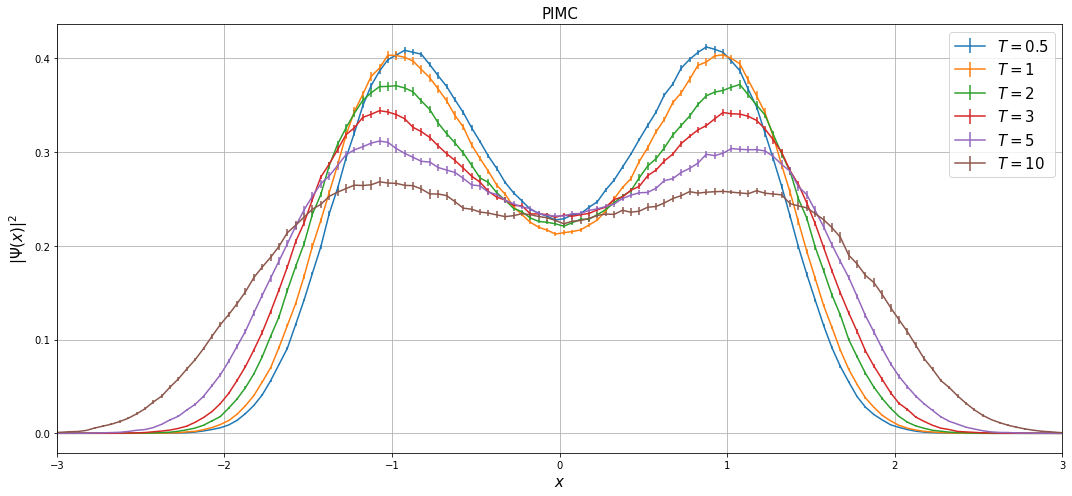

In [173]:
def plot_densities_PIMC(directory):
    """
    Plot pdfs for PIMC method for different temperatures.
    """
    
    temp_list = [0.5, 1, 2, 3, 5, 10]
    file_list = ["T0.5", "T1", "T2", "T3", "T5", "T10"]
    
    plt.figure(figsize=(15, 7))
    
    for i, file in enumerate(file_list):
        x, pdf, pdf_err = np.loadtxt(directory + file + "/probability.dat", unpack=True)
        plt.errorbar(x, pdf, pdf_err, label=r"$T=$"+str(temp_list[i]))
    
    plt.xlabel(r"$x$", size=15)
    plt.ylabel(r"$|\Psi(x)|^2$", size=15)
    plt.legend(fontsize=15)
    plt.grid()
    plt.xlim((-3, 3))
    plt.title("PIMC", fontsize=15)

    plt.tight_layout()
    plt.show()
    
plot_densities_PIMC("data/PIMC/")